# Boston Housing Dataset
- 보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Data 준비
- DataLoader 사용

In [12]:
#1. Data 읽어오기
df = pd.read_csv("data/boston_hosing.csv")

#2. input, output 분리
bs_input = df.drop(columns="MEDV").values # .values -> dataframe -> Numpy 배열이됨
bs_output = df['MEDV'].values.reshape(-1, 1) # 2차원 배열 형태로 변환
# 기존에는 (506, )의 형태이지만 (506, 1)형태로 변경된 것을 확인
# 바꾸는 이유 ?
# 행렬 연산 : 머신러닝 및 딥러닝 모델은 선형 대수의 개념을 활용
#             이러한 모델에서는 데이터를 행렬로 다루어야 하므로 2차원 배열 형태로 데이터를 준비하는 것이 적합

#3. input, output 데이터 타입을 float32로 변경
# 64 -> 32로 변경하면 메모리 사용량이 감소하기 때문
bs_input = bs_input.astype("float32")
bs_output = bs_output.astype("float32")

#4. train / test set 분리
X_train, X_test, y_train, y_test = train_test_split(
    bs_input, bs_output, test_size=0.2, random_state=0
)

#5. 전처리 - Feature Scaling(Feature 간의 scaling 값의 범위를 통일)
## train set 기반으로 학습하고 test를 변경.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#6. Dataset 생성 - tensor 형태로 생성
trainset = TensorDataset(
    torch.tensor(X_train_scaled),
    torch.tensor(y_train)
)
testset = TensorDataset(
    torch.tensor(X_test_scaled),
    torch.tensor(y_test)
)

#7. DataLoader 
## Dataset을 미니배치 학습, 데이터 shuffle=True 사용하기 위해
train_loader = DataLoader(
    trainset,
    batch_size=200,
    shuffle=True,
    drop_last=True
)
test_loader = DataLoader(
    testset,
    len(testset) # batch 크기를 test_loader의 sample 개수로 설정
    #즉, 테스트 데이터셋을 1개의 미니 배치로 처리하기 위해서
)

# 2. 모델 정의

In [15]:
class BostonModel(nn.Module):
    # nn.Module을 상속받는 새로운 BostonModel class 정의.
    # nn.Module : 상속받은 클래스 내에서 다른 모듈들을 포함하여 딥러닝 모델 구성 가능(레이어, 활성화 함수, 풀링 레이어)

    def __init__(self):
        #1. 상위 클래스 초기화(필수)
        super().__init__()
        #2. instance 변수 초기화
        self.lr1 = nn.Linear(in_features=13, out_features=32) # in_features는 특성 개수(즉, column 개수)
        self.lr2 = nn.Linear(32, 16)
        self.lr3 = nn.Linear(16, 1)
        #3. 활성함수 Layer
        self.relu = nn.ReLU()

    def forward(self, X):
        # __init__()에서 초기화한 layer 함수들을 이용해 추론 작업흐름을 정의
        out = self.lr1(X)
        out = self.relu(out)
        out = self.lr2(out)
        out = self.relu(out)
        out = self.lr3(out)
        # 일반적으로 회귀문제에서는 출력값의 범위에 특별한 제한을 두지 않아 활성화 함수를 사용하지 않음.
        return out


In [17]:
# 모델 instance 생성
boston_model = BostonModel()
# 모델 구조 확인
print(boston_model) # layer출력
# 학습중 사용하는 batch_size는 200으로 유지하면서 모델 요약에서는 100으로 설정
summary(boston_model, (100, 13)) 

BostonModel(
  (lr1): Linear(in_features=13, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=16, bias=True)
  (lr3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [100, 1]                  --
├─Linear: 1-1                            [100, 32]                 448
├─ReLU: 1-2                              [100, 32]                 --
├─Linear: 1-3                            [100, 16]                 528
├─ReLU: 1-4                              [100, 16]                 --
├─Linear: 1-5                            [100, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

# 3. Train

In [27]:
#1. 모델, Loss함수, optimizer 준비
epochs = 500
lr = 0.001 # 학습률
device = "cuda" if torch.cuda.is_available() else "cpu" # device 설정

bs_model = BostonModel().to(device)
loss_fn = nn.MSELoss() # MSELoss : 회귀에서 자주 사용
# MSELoss 함수는 예측값과 실제값 사이의 차이를 제곱하여 평균을 구함
# 오차를 직관적으로 반영하여 큰 오차를 반환할 수록 모델이 큰 오차를 줄이도록 학습됨
optimizer = optim.RMSprop(
    bs_model.parameters(),
    lr=lr
)
# RMSprop : 최적화 알고리즘, 학습률(lr)을 각 파라미터에 대해 개별적으로 조정
#           변화가 큰 그래디언트에서는 학습률을 낮추고, 변화가 작은 그래디언트에서는 학습률을 높이는 방식으로 조정

In [28]:
#2. train + evaluation
import time

# epoch 별 검증 결과를 저장할 변수
train_loss_list = []
valid_loss_list = []

s = time.time()
for epoch in range(epochs):
    ##1. 모델 train 모델로 변환
    bs_model.train()
    train_loss = 0.0
    ##2. batch 단위로 학습
    for X_train, y_train in train_loader:
        # 1개 step 학습
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred_train = bs_model(X_train) # bs_model 모델 추정 -> BostonModel의 bs_model.forward() 호출
        loss = loss_fn(pred_train, y_train) # 예측값과 실제값으 오차 계산
        loss.backward() # 모델 파라미터들의 gradient 계산
        optimizer.step() # 파라미터 업데이트
        optimizer.zero_grad() # 파라미터의 gradient값 초기화
        train_loss += loss.item() #loss 를 train_loss에 누적
    
    ##3. 1개의 epoch이 학습이 완료되었으며 train_loss의 평균을 계산.
    train_loss /= len(train_loader)

    ########################################################################################################################################################
    ##4. 모델 evaluation 모드로 변환
    bs_model.eval()
    val_loss = 0.0
    with torch.no_grad(): # 평가 단계는 gradient 계산을 안함
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred_val = bs_model(X_val) # 모델을 이용해 추정
            loss_val = loss_fn(pred_val, y_val)
            val_loss += loss_val.item()
        # val_loss 평균 계산
        val_loss /= len(test_loader)
    #5. 1개 epoch의 학습 /검증 완료 -> train_loss, val_loss를 list에 추가.
    train_loss_list.append(train_loss)
    valid_loss_list.append(val_loss)
    print(f"[{epoch+1:04d}/{epochs}] train loss: {train_loss} validation loss: {val_loss}")
e = time.time()
print(f"학습에 걸린시간 : {e-s} 초")




[0001/500] train loss: 598.6983337402344 validation loss: 571.1533813476562
[0002/500] train loss: 591.4871520996094 validation loss: 563.3312377929688
[0003/500] train loss: 584.1036987304688 validation loss: 554.33740234375
[0004/500] train loss: 571.2887878417969 validation loss: 544.0347290039062
[0005/500] train loss: 560.2904663085938 validation loss: 532.6097412109375
[0006/500] train loss: 542.2412719726562 validation loss: 520.1708374023438
[0007/500] train loss: 535.2991485595703 validation loss: 506.4789123535156
[0008/500] train loss: 515.0075378417969 validation loss: 491.7601013183594
[0009/500] train loss: 502.60675048828125 validation loss: 475.9747314453125
[0010/500] train loss: 483.0397644042969 validation loss: 459.5716552734375
[0011/500] train loss: 467.19537353515625 validation loss: 442.490966796875
[0012/500] train loss: 440.78773498535156 validation loss: 425.0748291015625
[0013/500] train loss: 429.37127685546875 validation loss: 407.1717834472656
[0014/500] 

# 학습 결과를 시각화

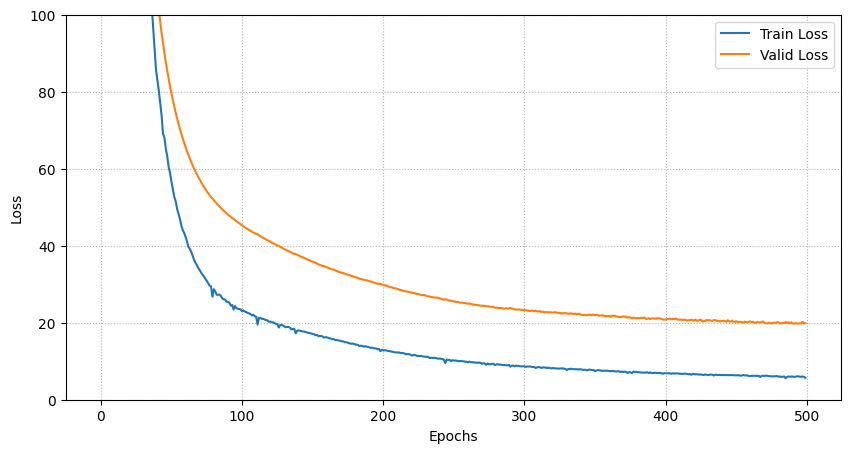

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss_list, label='Train Loss')
plt.plot(range(epochs), valid_loss_list, label='Valid Loss')
plt.ylim(0, 100)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

# 모델 저장 및 load

In [35]:
bs_model_save_path = "saved_models/boston_model.pth"

#1. 모델 저장
torch.save(bs_model, bs_model_save_path)

#2. 모델 load
load_model = torch.load(bs_model_save_path)

# 새로운 데이터 추정

In [40]:
new_data = torch.tensor(X_test_scaled[:10])

load_model.eval()
with torch.no_grad():
    y_hat = load_model(new_data)

print(y_hat)
print(y_test[:10])

tensor([[22.8500],
        [27.6847],
        [24.7209],
        [11.1711],
        [18.7099],
        [19.2984],
        [23.8040],
        [21.7565],
        [20.9170],
        [15.2910]])
[[22.6]
 [50. ]
 [23. ]
 [ 8.3]
 [21.2]
 [19.9]
 [20.6]
 [18.7]
 [16.1]
 [18.6]]
